# 3D shape identification algorithm

### Extract the measures from the 3D mesh files
Specify the path to the folder where the files are stored (line 209) <br> Specify the folder and file name to store the extracted measures (line 204)

In [ ]:
import numpy as np
import glob
import os
import pandas as pd
from scipy.spatial import ConvexHull, QhullError
from sklearn.decomposition import PCA
from numpy.fft import fft

def load_stl(folder_path):
    # Function to load all STL files and extract vertices (Binary STL only)
    vertices_dict = {}
    for file_path in glob.glob(os.path.join(folder_path, '**/*.stl'), recursive=True):
        print(f"Loading {file_path}...")
        with open(file_path, 'rb') as file:
            data = np.fromfile(file, dtype=np.uint8, count=-1, offset=84)
            data = data.reshape((-1, 50))
            data = data[:, :48]
            data = data.reshape((-1, 4))[:, 1:]
            vertices = data.reshape((-1, 3))
            vertices_dict[file_path] = vertices
    return vertices_dict

def compute_cross_sectional_areas(vertices, axis_index, n_sections=9):  # Modify according to the n_sections desired
    # Compute cross-sectional areas along a specified axis
    min_val = np.min(vertices[:, axis_index])
    max_val = np.max(vertices[:, axis_index])
    step = (max_val - min_val) / n_sections
    areas = []
    for i in range(n_sections):
        val = min_val + i * step
        cross_section = vertices[np.abs(vertices[:, axis_index] - val) < step / 2]
        if len(cross_section) > 2:
            # Projecting vertices to a plane perpendicular to the chosen axis
            proj_vertices = np.delete(cross_section, axis_index, axis=1)
            try:
                hull = ConvexHull(proj_vertices)
                areas.append(hull.area)
            except QhullError:
                areas.append(0)
        else:
            areas.append(0)
    return areas

def perform_pca_and_get_dimensions(vertices):
    pca = PCA(n_components=3)
    pca.fit(vertices)
    transformed = pca.transform(vertices)
    min_vals = np.min(transformed, axis=0)
    max_vals = np.max(transformed, axis=0)
    dimensions = max_vals - min_vals
    return dimensions, pca.explained_variance_ratio_, pca.components_

def calculate_curvature(vertices):
    curvatures = []
    for i in range(0, len(vertices), 3):  # Assuming vertices are in sets of 3 (triangular facets)
        p1, p2, p3 = vertices[i], vertices[i+1], vertices[i+2]
        v1 = p2 - p1
        v2 = p3 - p1

        # Calculate norms
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        if norm_v1 > 1e-6 and norm_v2 > 1e-6:  # Check to avoid division by zero
            dot_product = np.dot(v1, v2)
            dot_product = np.clip(dot_product / (norm_v1 * norm_v2), -1.0, 1.0)  # Clipping to avoid invalid values for arccos
            angle = np.arccos(dot_product)
            curvatures.append(angle)
    
    if curvatures:
        return np.mean(curvatures)
    else:
        return 0

def calculate_fourier_descriptors(vertices, num_descriptors=5):
    # Calculating for XY plane
    vertices_2d_xy = vertices[:, :2]
    fourier_result_xy = fft(vertices_2d_xy, axis=0)
    descriptors_xy = np.abs(fourier_result_xy[:num_descriptors]).flatten()

    # Calculating for XZ plane
    vertices_2d_xz = vertices[:, [0, 2]]  # X and Z coordinates
    fourier_result_xz = fft(vertices_2d_xz, axis=0)
    descriptors_xz = np.abs(fourier_result_xz[:num_descriptors]).flatten()

    # Calculating for YZ plane
    vertices_2d_yz = vertices[:, 1:]  # Y and Z coordinates
    fourier_result_yz = fft(vertices_2d_yz, axis=0)
    descriptors_yz = np.abs(fourier_result_yz[:num_descriptors]).flatten()

    # Combine descriptors from all planes
    return np.concatenate([descriptors_xy, descriptors_xz, descriptors_yz])

def calculate_fourier_descriptors_for_cross_section(cross_section, num_descriptors=5):
    # Assuming cross_section is a 2D array of vertices for the cross section
    fourier_result = fft(cross_section, axis=0)
    return np.abs(fourier_result[:num_descriptors]).flatten()

def compute_fourier_descriptors_cross_sections(vertices, axis_index, n_sections=9, num_descriptors=5):  # Modify according to the n_sections desired
    # Similar steps as in compute_cross_sectional_areas but with Fourier descriptors
    min_val = np.min(vertices[:, axis_index])
    max_val = np.max(vertices[:, axis_index])
    step = (max_val - min_val) / n_sections
    descriptors = []
    for i in range(n_sections):
        val = min_val + i * step
        cross_section = vertices[np.abs(vertices[:, axis_index] - val) < step / 2]
        if len(cross_section) > 2:
            # Projecting vertices to a plane perpendicular to the chosen axis
            proj_vertices = np.delete(cross_section, axis_index, axis=1)
            fourier_descriptors = calculate_fourier_descriptors_for_cross_section(proj_vertices, num_descriptors)
            descriptors.extend(fourier_descriptors)
        else:
            descriptors.extend([0] * num_descriptors * 2)  # Assuming 2D Fourier Descriptors
    return descriptors


def calculate_sphericity(volume, surface_area):
    return (np.pi ** (1 / 3) * (6 * volume) ** (2 / 3)) / surface_area

def calculate_roundness(vertices):
    hull = ConvexHull(vertices)
    sphere_radius = np.cbrt((3 * hull.volume) / (4 * np.pi))
    return hull.area / (4 * np.pi * sphere_radius ** 2)

def calculate_compactness_aabb(vertices):
    min_vals = np.min(vertices, axis=0)
    max_vals = np.max(vertices, axis=0)
    dimensions = max_vals - min_vals
    hull = ConvexHull(vertices)
    volume = hull.volume
    return volume / (np.linalg.norm(dimensions) ** 3)

def extract_features(vertices):
    dimensions, variance_ratios, principal_axes = perform_pca_and_get_dimensions(vertices)
    hull = ConvexHull(vertices)
    volume = hull.volume
    surface_area = hull.area
    aspect_ratios = [dimensions[0]/dimensions[1], dimensions[1]/dimensions[2], dimensions[0]/dimensions[2]]
    elongation = max(dimensions) / min(dimensions)
    compactness = volume / (np.linalg.norm(dimensions) ** 3)
    compactness_aabb = calculate_compactness_aabb(vertices)
    eccentricity = np.sqrt(1 - (min(dimensions) / max(dimensions)) ** 2)
    cross_sectional_areas_x = compute_cross_sectional_areas(vertices, axis_index=0)
    cross_sectional_areas_y = compute_cross_sectional_areas(vertices, axis_index=1)
    cross_sectional_areas_z = compute_cross_sectional_areas(vertices, axis_index=2)
    volume_to_surface_area = volume / surface_area
    curvature = calculate_curvature(vertices)
    fourier_descriptors = calculate_fourier_descriptors(vertices)
    fourier_descriptors_x = compute_fourier_descriptors_cross_sections(vertices, axis_index=0)
    fourier_descriptors_y = compute_fourier_descriptors_cross_sections(vertices, axis_index=1)
    fourier_descriptors_z = compute_fourier_descriptors_cross_sections(vertices, axis_index=2)
    sphericity = calculate_sphericity(volume, surface_area)
    roundness = calculate_roundness(vertices)

    return np.array([*dimensions, volume, surface_area, *aspect_ratios, elongation, compactness, compactness_aabb, eccentricity, *cross_sectional_areas_x, *cross_sectional_areas_y, *cross_sectional_areas_z, volume_to_surface_area, *variance_ratios, *principal_axes.flatten(), curvature, *fourier_descriptors, *fourier_descriptors_x, *fourier_descriptors_y, *fourier_descriptors_z, sphericity, roundness])

def process_stl_files(folder_path):
    features = []
    file_info = []
    vertices_dict = load_stl(folder_path)

    for file_path, vertices in vertices_dict.items():
        print(f"Processing {file_path}...")
        model_features = extract_features(vertices)
        features.append(model_features)
        file_name = os.path.basename(file_path)
        folder_name = os.path.dirname(file_path)
        file_info.append((file_name, folder_name))

    return np.array(features), file_info

def export_to_csv(features, file_info, folder_path):
    column_names = [
        'Length', 'Width', 'Height', 'Volume', 'Surface Area',
        'Aspect Ratio 1', 'Aspect Ratio 2', 'Aspect Ratio 3',
        'Elongation', 'Compactness', 'Compactness_aabb', 'Eccentricity',
        'Cross-Sectional Area X1', 'Cross-Sectional Area X2', 'Cross-Sectional Area X3', 'Cross-Sectional Area X4', 'Cross-Sectional Area X5', 'Cross-Sectional Area X6', 'Cross-Sectional Area X7', 'Cross-Sectional Area X8', 'Cross-Sectional Area X9',  # Assuming 5 sections as per n_sections
        'Cross-Sectional Area Y1', 'Cross-Sectional Area Y2', 'Cross-Sectional Area Y3', 'Cross-Sectional Area Y4', 'Cross-Sectional Area Y5', 'Cross-Sectional Area Y6', 'Cross-Sectional Area Y7', 'Cross-Sectional Area Y8', 'Cross-Sectional Area Y9',  # Assuming 5 sections as per n_sections
        'Cross-Sectional Area Z1', 'Cross-Sectional Area Z2', 'Cross-Sectional Area Z3', 'Cross-Sectional Area Z4', 'Cross-Sectional Area Z5', 'Cross-Sectional Area Z6', 'Cross-Sectional Area Z7', 'Cross-Sectional Area Z8', 'Cross-Sectional Area Z9',  # Assuming 5 sections as per n_sections
        'Volume to Surface Area Ratio', 'PCA Variance Ratio 1', 'PCA Variance Ratio 2', 'PCA Variance Ratio 3',
        'PCA Component 1-1', 'PCA Component 1-2', 'PCA Component 1-3',
        'PCA Component 2-1', 'PCA Component 2-2', 'PCA Component 2-3',
        'PCA Component 3-1', 'PCA Component 3-2', 'PCA Component 3-3',
        'Curvature', 'Sphericity', 'Roundness'
    ]

    # Adding column names for Fourier descriptors from XY, XZ, YZ projections
    for plane in ['XY', 'XZ', 'YZ']:
        for descriptor in range(1, 11):  # Assuming 10 descriptors
            column_names.append(f'Fourier Descriptor {plane}-{descriptor}')

    # Adding column names for Fourier descriptors for each cross section
    for axis in ['X', 'Y', 'Z']:
        for section in range(1, 10):  # Assuming 9 sections as per n_sections
            for descriptor in range(1, 11):  # Assuming 10 descriptors
                column_names.append(f'Cross-Section Fourier Descriptor {axis}{section}-{descriptor}')

    df = pd.DataFrame(features, columns=column_names)
    df['File Name'] = [info[0] for info in file_info]
    df['Folder Path'] = [info[1] for info in file_info]
    df['Class'] = ''  # Add an empty 'Class' column for user to fill in later

    output_path = os.path.join(os.path.dirname(folder_path), 'seed_measurements_7th measures_matched40k.csv')
    df.to_csv(output_path, index=False)
    print(f"Data exported to {output_path}")

# Specify the folder path
folder_path = 'C:/ProofsML/OrientedMatched_40K_L50'  # Replace with the folder path in which the stl files are stored (it will also extract the files from subfolders)
features, file_info = process_stl_files(folder_path)

# Export the measurements to CSV
export_to_csv(features, file_info, folder_path)


### Normalise the values of the cvs  --> It seems normalisation makes no difference and standarisation makes it worse at least for RF, try linear classifiers

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_and_round_csv(input_file, output_file):
    """
    Reads a CSV file, normalizes numerical columns to a range of 0 to 1 (excluding all-NaN columns),
    rounds them to 4 decimal places, and saves the result to a new CSV file.
    """
    # Load the CSV file
    df = pd.read_csv(input_file)

    # Select numerical columns and exclude columns with all NaN values
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_normalize = [col for col in numerical_cols if not df[col].isna().all()]

    # Normalize the selected columns
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

    # Round to 4 decimal places
    df[cols_to_normalize] = df[cols_to_normalize].round(4)

    # Save to new CSV file
    df.to_csv(output_file, index=False)
    print(f"Normalized and rounded CSV saved to {output_file}")

# Main
if __name__ == "__main__":
    # Manually set the input and output file paths
    input_file_path = 'C:/ProofsML/measure_tables/1st measures/Dundee_Orkney/seed_measurements_T6level.csv'  # Replace with your input file path
    output_file_path = 'C:/ProofsML/measure_tables/2nd measures/seed_measurements_original_norm.csv'  # Replace with your output file path

    normalize_and_round_csv(input_file_path, output_file_path)


Normalized and rounded CSV saved to C:/ProofsML/measure_tables/2nd measures/seed_measurements_original_norm.csv


### Get information about the structure of your CSV --> check why are there values with a value of 0 and outliers.
Analysis of bad scan? If analysis: shape transformation with spherical harmonics (to blame for the lack of difference between basic measures such as length?) or bad calculation in the extraction of measures (to blame for outliers?)

In [23]:
import pandas as pd

# Load the CSV file
file_path = 'C:/ProofsML/measure_tables/1st_basic/seed_measurements_2nd_basic_measures_matched40k.csv'  # Update this with the actual file path
df = pd.read_csv(file_path)

# Get some basic stats on the file
print("Basic File Stats:")
print(df.info())  # This will include the total number of columns
print()

# For each column, display the first and last 5 rows of unique values
for column in df.columns:
    unique_values = pd.unique(df[column])
    print(f'Column: {column}')
    # Check if there are more than 10 unique values to display them as requested
    if len(unique_values) > 10:
        print(f'Unique values (first 5): {unique_values[:5]}')
        print(f'Unique values (last 5): {unique_values[-5:]}')
    else:  # If 10 or fewer unique values, just print them all
        print(f'Unique values: {unique_values}')
    print('-----------------------------------------------------')

# Additional statistical summary for numerical columns
print("Statistical Summary for Numerical Columns:")
print(df.describe())


Basic File Stats:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   File Name    707 non-null    object 
 1   FD X1        707 non-null    float64
 2   FD X2        707 non-null    float64
 3   FD X3        707 non-null    float64
 4   FD X4        707 non-null    float64
 5   FD X5        707 non-null    float64
 6   FD Y1        707 non-null    float64
 7   FD Y2        707 non-null    float64
 8   FD Y3        707 non-null    float64
 9   FD Y4        707 non-null    float64
 10  FD Y5        707 non-null    float64
 11  FD Z1        707 non-null    float64
 12  FD Z2        707 non-null    float64
 13  FD Z3        707 non-null    float64
 14  FD Z4        707 non-null    float64
 15  FD Z5        707 non-null    float64
 16  Folder Path  707 non-null    object 
 17  class        0 non-null      float64
dtypes: float64(16), object(2)
memory

### Select the column and values within it to create the class values in the csv file 'class' column

In [24]:

# Function to update the 'class' column based on selected unique values from a specific column
def update_class_column(df, column_name, class_mapping):
    '''
    Update the 'class' column in the DataFrame based on selected unique values from a specific column.
    
    Parameters:
    df (DataFrame): The DataFrame to be updated.
    column_name (str): The name of the column whose values will be used to populate the 'class' column.
    class_mapping (dict): A dictionary mapping the unique values of the selected column to the class names.
    '''
    df['Class'] = df[column_name].map(class_mapping)
    return df

# Example usage
column_to_use = 'Folder Path'
mapping = {'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\2ROW British': 'Brit',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\2ROW Scottish': 'Scot',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\6ROW Bere\\6ROW BERE Orkney': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\6ROW Bere\\6ROW BERE Unknown': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\6ROW Bere\\6ROW BERE Western Isles': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\6ROW Faro': 'Faro',
           'C:/ProofsML/OrientedMatched_40K_L50\\Dundee\\6ROW Scandinavian': 'Scand',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\2ROW British': 'Brit',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\2ROW Scottish': 'Scot',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\6ROW Bere\\6ROW BERE ORKNEY': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\6ROW Bere\\6ROW BERE Unknown': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\6ROW Bere\\6ROW BERE Western Isles': 'Bere',
           'C:/ProofsML/OrientedMatched_40K_L50\\Orkney\\6ROW Scandinavian': 'Scand',}
update_class_column(df, column_to_use, mapping)

# Save the updated DataFrame to a new CSV file
output_file_path = 'C:/ProofsML/measure_tables/1st_basic/Brit_Scot_Scand_Bere/2nd_seed_measurements_matched40k.csv'  # Update this with the actual output file path
df.to_csv(output_file_path, index=False)


### PCA: for lineal classifiers

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the data
file_path = 'C:/ProofsML/measure_tables/7th measures/Brit_Scot_Scand_Bere/seed_measurements_matched40k.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Isolating the numerical and non-numerical columns
numerical_data = data.select_dtypes(include=[np.number])
non_numerical_data = data.select_dtypes(exclude=[np.number])

# Standardizing the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Applying PCA
pca = PCA(n_components=30)
principal_components = pca.fit_transform(scaled_data)

# Converting the principal components into a DataFrame
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(30)])

# Concatenating the non-numerical data with the principal components
final_df = pd.concat([non_numerical_data, principal_df], axis=1)

# Save the combined data to a new CSV file
final_df.to_csv('C:/ProofsML/measure_tables/7th measures/Brit_Scot_Scand_Bere/seed_measurements_matched40k_PCA30.csv', index=False)

# Optional: Print statements
# To view the explained variance ratio
print(pca.explained_variance_ratio_)

# To view the first few rows of the transformed data
print(final_df.head())


[0.11015464 0.05115394 0.04050542 0.03557011 0.02715149 0.02276446
 0.01882373 0.01675466 0.01525612 0.01372545 0.0132339  0.01258637
 0.01165993 0.01107172 0.01039937 0.00989033 0.00971672 0.00917188
 0.00879718 0.00839868 0.00792173 0.00788713 0.00768848 0.00736655
 0.00704431 0.00676973 0.00675738 0.00638348 0.0063124  0.00615296]
           File Name                                        Folder Path Class  \
0   DHBT16P103 1.stl  C:/ProofsML/OrientedMatched_40K_L50\Dundee\2RO...  Brit   
1  DHBT16P103 10.stl  C:/ProofsML/OrientedMatched_40K_L50\Dundee\2RO...  Brit   
2   DHBT16P103 2.stl  C:/ProofsML/OrientedMatched_40K_L50\Dundee\2RO...  Brit   
3   DHBT16P103 3.stl  C:/ProofsML/OrientedMatched_40K_L50\Dundee\2RO...  Brit   
4   DHBT16P103 4.stl  C:/ProofsML/OrientedMatched_40K_L50\Dundee\2RO...  Brit   

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  ...  \
0 -9.070185 -8.346400 -2.854947  2.112223  0.187751 -2.250941  0.375095  ...   
1 -9.695905  1.96

### Select, execute, and validate the classifier

Classification Report for lda:
               precision    recall  f1-score   support

           0     0.8333    0.8235    0.8284        85
           1     0.7414    0.7544    0.7478        57

    accuracy                         0.7958       142
   macro avg     0.7874    0.7890    0.7881       142
weighted avg     0.7964    0.7958    0.7961       142

Confusion Matrix for lda:
 [[70 15]
 [14 43]]


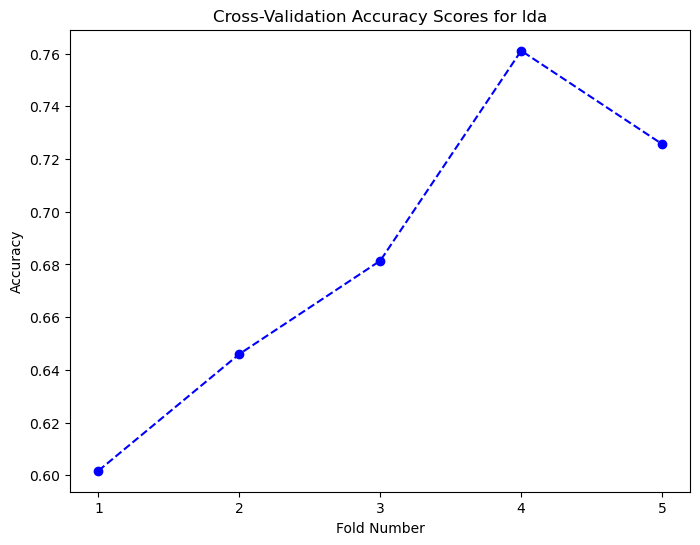

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('C:/ProofsML/measure_tables/7th measures/Dundee_Orkney/seed_measurements_matched40k.csv')

# Preprocess data
X = df.drop(['File Name', 'Folder Path', 'Class'], axis=1).values
y = LabelEncoder().fit_transform(df['Class'].values)  # Convert classes to integers

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the classifier
classifier_name = 'lda'  # Options: 'rf', 'gbm', 'svm', 'knn', 'fcnn'

if classifier_name == 'fcnn':
    # FCNN setup
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"Classification Report for FCNN:\n", classification_report(y_test, y_pred, digits=4))
    print(f"Confusion Matrix for FCNN:\n", confusion_matrix(y_test, y_pred))

else:
    # Traditional classifiers setup
    classifiers = {
        'rf': RandomForestClassifier(n_estimators=675, random_state=42),
        'gbm': GradientBoostingClassifier(random_state=42),
        'svm': SVC(random_state=42),
        'knn': KNeighborsClassifier(),
        'lda': LinearDiscriminantAnalysis()
    }
    classifier = classifiers[classifier_name]

    # Perform cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy')

    # Train the model
    classifier.fit(X_train, y_train)

    # Predictions and Evaluation
    y_pred = classifier.predict(X_test)
    print(f"Classification Report for {classifier_name}:\n", classification_report(y_test, y_pred, digits=4))
    print(f"Confusion Matrix for {classifier_name}:\n", confusion_matrix(y_test, y_pred))

    # Visualize the results of cross-validation
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
    plt.title(f'Cross-Validation Accuracy Scores for {classifier_name}')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.show()


# Alternative LOO Cros-validation

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load your dataframe
df = pd.read_csv('C:/ProofsML/measure_tables/7th measures/Brit_Scot_Scand_Bere/seed_measurements_matched40k.csv')

# Preprocess data
le = LabelEncoder()
y = le.fit_transform(df['Class'].values)  # Convert classes to integers
X = df.drop(['File Name', 'Folder Path', 'Class'], axis=1).values

# Specify the classifier
classifier_name = 'gbm'  # Options: 'rf', 'gbm', 'svm', 'knn', 'lda'

# Setup classifiers
classifiers = {
    'rf': RandomForestClassifier(n_estimators=150, random_state=42),
    'gbm': GradientBoostingClassifier(random_state=42),
    'svm': SVC(random_state=42),
    'knn': KNeighborsClassifier(),
    'lda': LinearDiscriminantAnalysis()
}

classifier = classifiers[classifier_name]

# Initialize LeaveOneOut
loo = LeaveOneOut()

# Use cross_val_predict to make predictions for each leave-one-out split
y_pred = cross_val_predict(classifier, X, y, cv=loo, n_jobs=-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(f"Overall LOOCV Confusion Matrix for {classifier_name}:\n{conf_matrix}")

# Compute classification report
class_report = classification_report(y, y_pred, digits=4, zero_division=0)
print(f"Classification Report for {classifier_name}:\n{class_report}")

# Compute per-class accuracies
class_names = le.classes_
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, acc in enumerate(class_accuracies):
    print(f"Accuracy for class '{class_names[idx]}': {acc:.4f}")


Overall LOOCV Confusion Matrix for gbm:
[[141  11  19   6]
 [ 14 183  14  18]
 [ 19  32 102  10]
 [ 11  48  12  57]]
Classification Report for gbm:
              precision    recall  f1-score   support

           0     0.7622    0.7966    0.7790       177
           1     0.6679    0.7991    0.7276       229
           2     0.6939    0.6258    0.6581       163
           3     0.6264    0.4453    0.5205       128

    accuracy                         0.6930       697
   macro avg     0.6876    0.6667    0.6713       697
weighted avg     0.6903    0.6930    0.6864       697

Accuracy for class 'Bere': 0.7966
Accuracy for class 'Brit': 0.7991
Accuracy for class 'Scand': 0.6258
Accuracy for class 'Scot': 0.4453


## Find the best number of trees

Done for 50 trees: Accuracy = 0.6585365853658537
Done for 100 trees: Accuracy = 0.6657101865136298
Done for 150 trees: Accuracy = 0.6743185078909613
Done for 200 trees: Accuracy = 0.672883787661406
Done for 250 trees: Accuracy = 0.667144906743185
Done for 300 trees: Accuracy = 0.6657101865136298
Done for 350 trees: Accuracy = 0.672883787661406
Done for 400 trees: Accuracy = 0.6700143472022956
Done for 450 trees: Accuracy = 0.6700143472022956
Done for 500 trees: Accuracy = 0.6757532281205165
Done for 550 trees: Accuracy = 0.6685796269727403
Done for 600 trees: Accuracy = 0.6700143472022956
Done for 650 trees: Accuracy = 0.6685796269727403
Done for 700 trees: Accuracy = 0.6685796269727403
Done for 750 trees: Accuracy = 0.6714490674318508
Done for 800 trees: Accuracy = 0.672883787661406
Done for 850 trees: Accuracy = 0.6700143472022956
Done for 900 trees: Accuracy = 0.6700143472022956
Done for 950 trees: Accuracy = 0.6685796269727403
Done for 1000 trees: Accuracy = 0.6657101865136298
Done

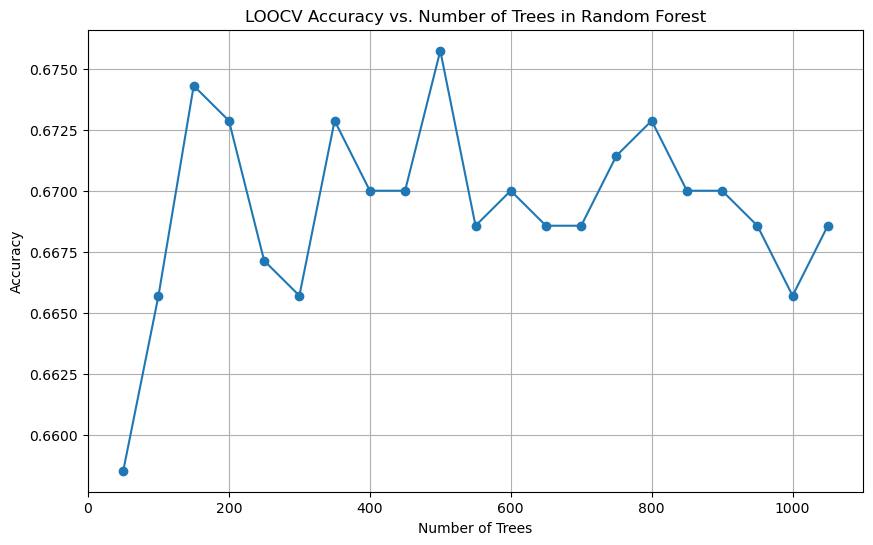

In [62]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load your data
# Make sure to replace the path with the correct one for your dataset
df = pd.read_csv('C:/ProofsML/measure_tables/7th measures/Brit_Scot_Scand_Bere/seed_measurements_matched40k.csv')

# Preprocess data
X = df.drop(['File Name', 'Folder Path', 'Class'], axis=1).values
y = LabelEncoder().fit_transform(df['Class'].values)  # Convert classes to integers

# Define the range of number of trees to test
min_trees = 50
max_trees = 1050
step_size = 50

# Initialize results storage
results = {'Number of Trees': [], 'Accuracy': []}

# Setup LeaveOneOut for cross-validation
loo = LeaveOneOut()

for n_trees in range(min_trees, max_trees + 1, step_size):
    classifier = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    
    # Use cross_val_predict to make predictions for each LOOCV split
    y_pred = cross_val_predict(classifier, X, y, cv=loo, n_jobs=-1)
    
    # Compute accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # Store results
    results['Number of Trees'].append(n_trees)
    results['Accuracy'].append(accuracy)
    print(f"Done for {n_trees} trees: Accuracy = {accuracy}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['Number of Trees'], results['Accuracy'], marker='o')
plt.title('LOOCV Accuracy vs. Number of Trees in Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()